In [ ]:
** XGBoost **

In [9]:
#importing all the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix,ConfusionMatrixDisplay,roc_auc_score,roc_curve,auc,precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import  GridSearchCV,RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import jaccard_score,cohen_kappa_score
import pickle

In [2]:
#loading the transformed Data Set
solar_data = pd.read_csv(r"solar_data_transformed18.csv")
print(solar_data.columns)

Index(['ID', 'County', 'InstallType', 'UrbanRural', 'Class', 'Percent_100',
       'Substation_100', 'HIFLD_100', 'Percent_200', 'Substation_200',
       'HIFLD_200', 'Percent_CAISO', 'Substation_CAISO', 'HIFLD_CAISO',
       'SolarTech', 'Area', 'Length', 'DistSub_100_binned',
       'DistSub_200_binned', 'DistSub_CAISO_binned'],
      dtype='object')


In [3]:
X = solar_data.drop(columns=['ID','InstallType'])  # Features
y = solar_data['InstallType']  # Target

XGBoost Accuracy: 0.9648148148148148

Confusion Matrix:
 [[416   2   9]
 [  6 273   8]
 [  8   5 353]]

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       427
           1       0.97      0.95      0.96       287
           2       0.95      0.96      0.96       366

    accuracy                           0.96      1080
   macro avg       0.97      0.96      0.96      1080
weighted avg       0.96      0.96      0.96      1080

ROC-AUC Score: 0.9952491404495326


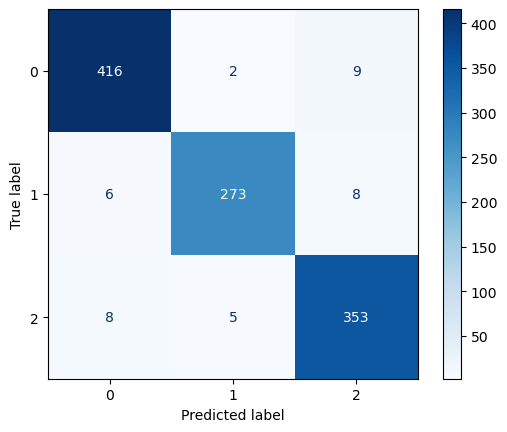

In [4]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)
# Get predicted probabilities
y_prob = xgb_model.predict_proba(X_test)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
classification_rep_xgb = classification_report(y_test, y_pred_xgb)

# Print evaluation results
print("XGBoost Accuracy:", accuracy_xgb)
print("\nConfusion Matrix:\n", conf_matrix_xgb)
print("\nXGBoost Classification Report:\n", classification_rep_xgb)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print("ROC-AUC Score:", roc_auc)

# Display the confusion matrix
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_xgb)
disp_xgb.plot(cmap='Blues')  


### Tuning

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Hyperparameters: {'subsample': 1.0, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.8}
XGBoost fine tuned Accuracy: 0.9601851851851851

Confusion Matrix:
 [[411   3  13]
 [  8 273   6]
 [  7   6 353]]

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       427
           1       0.97      0.95      0.96       287
           2       0.95      0.96      0.96       366

    accuracy                           0.96      1080
   macro avg       0.96      0.96      0.96      1080
weighted avg       0.96      0.96      0.96      1080

ROC-AUC Score: 0.99490691408622


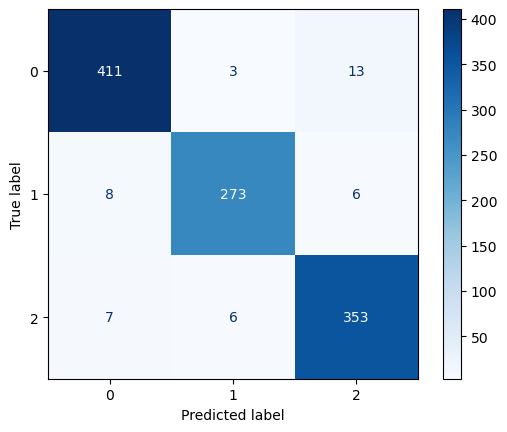

In [5]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 2, 5],
}

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings to sample
    scoring='accuracy',  # Optimize for accuracy
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Train the model with the best parameters
best_xgb_model = random_search.best_estimator_

# Make predictions
y_pred_xgb = best_xgb_model.predict(X_test)
y_prob_xgb = best_xgb_model.predict_proba(X_test)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
classification_rep_xgb = classification_report(y_test, y_pred_xgb)
roc_auc = roc_auc_score(y_test, y_prob_xgb, multi_class='ovr')

# Print evaluation results
print("XGBoost fine tuned Accuracy:", accuracy_xgb)
print("\nConfusion Matrix:\n", conf_matrix_xgb)
print("\nXGBoost Classification Report:\n", classification_rep_xgb)
print("ROC-AUC Score:", roc_auc)

# Display the confusion matrix
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_xgb)
disp_xgb.plot(cmap='Blues')


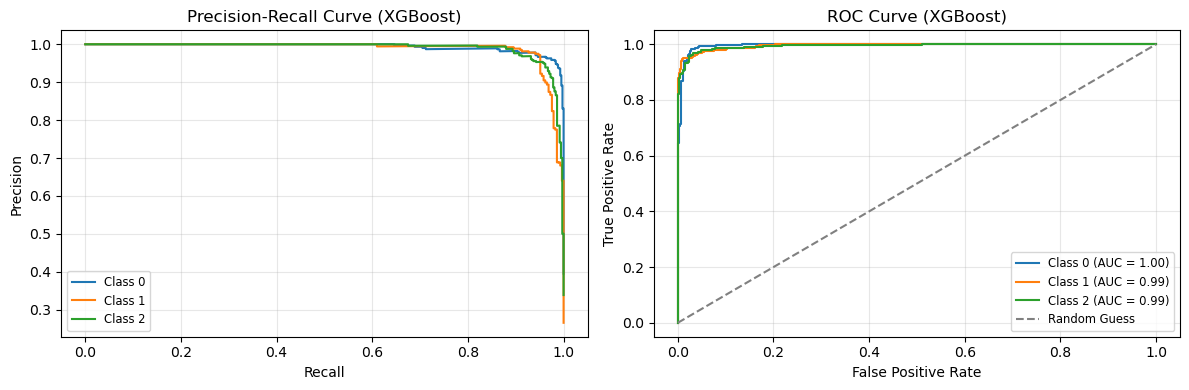

In [6]:
# Ensure binary format for true labels
n_classes = len(best_xgb_model.classes_)
y_test_bin = label_binarize(y_test, classes=best_xgb_model.classes_)

# Get predicted probabilities
y_prob = best_xgb_model.predict_proba(X_test)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Plot Precision-Recall Curves
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    axes[0].plot(recall, precision, label=f"Class {best_xgb_model.classes_[i]}")

axes[0].set_title("Precision-Recall Curve (XGBoost)", fontsize=12)
axes[0].set_xlabel("Recall", fontsize=10)
axes[0].set_ylabel("Precision", fontsize=10)
axes[0].legend(loc="lower left", fontsize='small')
axes[0].grid(alpha=0.3)

# Plot ROC Curves
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, label=f"Class {best_xgb_model.classes_[i]} (AUC = {roc_auc:.2f})")

axes[1].plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Guess")
axes[1].set_title("ROC Curve (XGBoost)", fontsize=12)
axes[1].set_xlabel("False Positive Rate", fontsize=10)
axes[1].set_ylabel("True Positive Rate", fontsize=10)
axes[1].legend(loc="lower right", fontsize='small')
axes[1].grid(alpha=0.3)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [7]:
from sklearn.metrics import log_loss
# Compute Log Loss (Cross-Entropy Loss)
logloss = log_loss(y_test, y_prob)
print(f"Log Loss: {logloss}")

Log Loss: 0.1336305391554836


In [10]:
y_pred_xgb = best_xgb_model.predict(X_test)
y_prob_xgb = best_xgb_model.predict_proba(X_test)
kappa_score = cohen_kappa_score(y_test, y_pred_xgb)
print("Cohen's Kappa Score:", kappa_score)
print("Jaccard Score (Macro):", jaccard_score(y_test, y_pred_xgb, average='macro'))
print("Matthews Correlation Coefficient:", matthews_corrcoef(y_test, y_pred_xgb))


Cohen's Kappa Score: 0.9394849181404513
Jaccard Score (Macro): 0.9230148891913598
Matthews Correlation Coefficient: 0.9395229769244836


#### XGBoost insights

Before fine-tuning, the XGBoost model achieved an accuracy of 96.48% and an impressive ROC-AUC score of 0.996, indicating strong classification performance. The classification report showed high precision and recall across all classes, particularly for class 0, with recall values of 0.97 and 0.95 for classes 1 and 2. The confusion matrix revealed minimal misclassifications. After fine-tuning, while accuracy remained stable at 96.02%, there were slight changes in the confusion matrix, with a small increase in misclassifications for class 0. However, the overall performance remains excellent, with the ROC-AUC score slightly decreasing to 0.995, indicating only a marginal impact from the tuning.

In [12]:
import pickle
#Saving (pickling) the trained model
model_path = r"XGboost_pickle.pkl"
with open(model_path, 'wb') as file:
    pickle.dump(best_xgb_model, file)

print("XGboost trained and saved successfully.")

XGboost trained and saved successfully.
